In [196]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [197]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [198]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [199]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [200]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [201]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [202]:
# Save references to each table
measurement = Base.classes.measurement
measurement_first_row = session.query(measurement).first()

station = Base.classes.station
station_first_row = session.query(station).first()

# Display First Row to gain column names and data types
print(measurement_first_row.__dict__)
print("------------------------------------------")
print(station_first_row.__dict__)


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000002AEC95C0070>, 'station': 'USC00519397', 'id': 1, 'tobs': 65.0, 'prcp': 0.08, 'date': '2010-01-01'}
------------------------------------------
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000002AEC95C0D00>, 'latitude': 21.2716, 'id': 1, 'elevation': 3.0, 'name': 'WAIKIKI 717.2, HI US', 'longitude': -157.8168, 'station': 'USC00519397'}


In [203]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [204]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()


('2017-08-23',)

Query Date: 2016-08-23


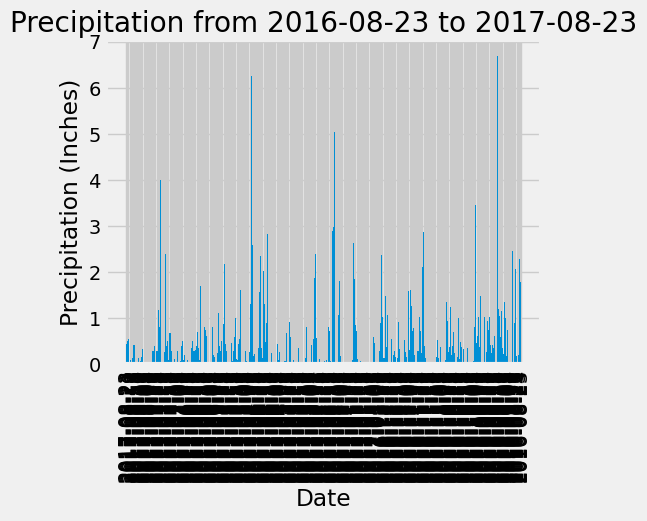

In [205]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
# From most recent date substract in datetime format 365 to view 12 month precip
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date:", query_date)

# Perform a query to retrieve the data and precipitation scores
data = []
twelve_month_precip = session.query(measurement.date, measurement.prcp).filter(measurement.date >= query_date).all()
for row in twelve_month_precip:
    data.append(row)
    
# Save the query results as a Pandas DataFrame. Explicitly set the column names
query_results_df = pd.DataFrame(data, columns=['date','prcp'])

# Sort the dataframe by date
query_results_sorted = query_results_df.sort_values(by='date', ascending=False)

# # Use Pandas Plotting with Matplotlib to plot the data
date = query_results_sorted['date']
prcp = query_results_sorted['prcp']

plt.figure(figsize=(5, 4))

plt.bar(date, prcp)
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Precipitation (Inches)')
plt.title('Precipitation from 2016-08-23 to 2017-08-23')

plt.show() 


In [206]:
# Use Pandas to calculate the summary statistics for the precipitation data
query_results_sorted.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [207]:
# Design a query to calculate the total number of stations in the dataset
session.query(station.station).count()


9

In [208]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station) \
                .order_by(func.count(measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [209]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = active_stations[0]['station']

sel = [func.min(measurement.tobs),
      func.max(measurement.tobs),
      func.avg(measurement.tobs)]

temperatures = session.query(*sel).filter(measurement.station == most_active).all()
temperatures

[(54.0, 85.0, 71.66378066378067)]

Query Date: 2016-08-18


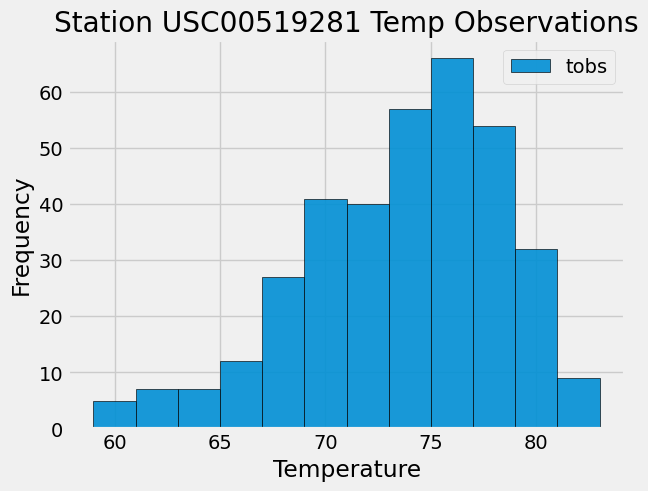

In [210]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Lastest query date for most active station
query_date = session.query(measurement.date).order_by(measurement.date.desc()).filter(measurement.station == most_active).first()

# 12 month temperature observation date
query_date = dt.date(2017, 8, 18) - dt.timedelta(days=365)
print("Query Date:", query_date)

# Filter query based on dates and most active station and append to list 
data = []
twelve_month_temp = session.query(measurement.date, measurement.tobs).filter(measurement.date >= query_date) \
.filter(measurement.station == most_active) \
.all()
for row in twelve_month_temp:
    data.append(row)
    
# Save the query results as a Pandas DataFrame. Explicitly set the column names
query_results_df = pd.DataFrame(data, columns=['date','tobs'])

# Sort the dataframe by date
query_results_sorted = query_results_df.sort_values(by='date', ascending=False)

query_results_sorted.plot.hist(y='tobs', bins=12, alpha=0.9, edgecolor='black')

# Adding labels and title
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f'Station {most_active} Temp Observations')

# Show the plot
plt.show()



# Close Session

In [211]:
# Close Session
session.close()